In [1]:
import patient as p
import tensorflow as tf
import numpy as np
import myLib
import consts as c



In [2]:
c.WINDOW_SIZE = c.PREPREDICTION_LENGTH + 1000

tabSegments = []
for pStr in c.trainPatients:
    tabSegments = tabSegments + p.patient(pStr).getLabeledSegments()


x_train,y_train = myLib.processDF(tabSegments)
x_validation,y_validation = myLib.processDF(p.patient(c.validationPatient).getLabeledSegments())
x_test,y_test = myLib.processDF(p.patient(c.testPatient).getLabeledSegments())




Loading data of patient MSEL_00172


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:25<00:00,  9.58it/s]


Loading data of patient MSEL_00501


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:32<00:00,  8.65it/s]


Loading data of patient MSEL_01097


100%|████████████████████████████████████████████████████████████████████████████████| 416/416 [00:50<00:00,  8.29it/s]


Loading data of patient MSEL_01575


100%|████████████████████████████████████████████████████████████████████████████████| 438/438 [00:42<00:00, 10.23it/s]


Loading data of patient MSEL_01808


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:38<00:00,  8.33it/s]


Loading data of patient MSEL_01838


100%|████████████████████████████████████████████████████████████████████████████████| 404/404 [00:48<00:00,  8.42it/s]


Loading data of patient MSEL_01842


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:34<00:00,  8.57it/s]


Loading data of patient MSEL_01844


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:38<00:00,  8.33it/s]


In [3]:
print(f"train data: {len(x_train)}\t validation: {len(x_validation)}\t test:{len(x_test)}\n")
unique, counts = np.unique(y_train, return_counts=True)

print(f"TRAIN:     Negatives: {counts[0]} Positives: {counts[1]}")
pos = counts[1]
neg = counts[0]
ratio = round(100 / len(x_train) * pos)
unique, counts = np.unique(y_validation, return_counts=True)
print(f"VALIDATION Negatives: {counts[0]} Positves: {counts[1]}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"TEST       Negatives: {counts[0]} Positves: {counts[1]}")


print(f"\n{ratio} % of positives")




train data: 2142	 validation: 309	 test:356

TRAIN:     Negatives: 2008 Positives: 134
VALIDATION Negatives: 297 Positves: 12
TEST       Negatives: 314 Positves: 42

6 % of positives


In [4]:

def getModel1():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(2,activation=tf.nn.softmax))

    #model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=[
              tf.keras.metrics.BinaryAccuracy(name='accuracy')
          ]
    )
    return model

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def getModel2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(x_train.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



In [5]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

initial_bias = np.log([pos/neg])

model = getModel2(output_bias=initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                82000     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 82,017
Trainable params: 82,017
Non-trainable params: 0
_________________________________________________________________


In [6]:
import math
results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
p0 = pos/(pos+neg)
expectedInitLoss = -p0 * math.log(p0) - (1 - p0) * math.log(1-p0)
print(f"Intial Loss: {round(results[0],4)} expected : {round(expectedInitLoss,4)}")

Intial Loss: 0.264 expected : 0.2339


In [7]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),"initial_weights")
model.save_weights(initial_weights)

In [8]:
model = getModel2()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(x_validation, y_validation), 
    verbose=0)

In [9]:
model = getModel2()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(x_validation, y_validation), 
    verbose=0)

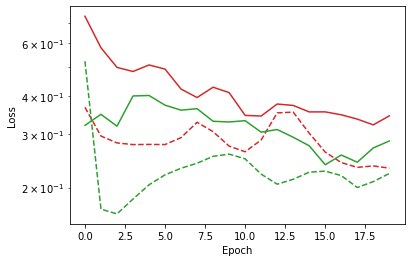

In [10]:
import matplotlib.pyplot as plt


def plot_loss(history, label, color = "C1"):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=color, label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


plot_loss(zero_bias_history, "Zero Bias","C3")
plot_loss(careful_bias_history, "Careful Bias","C2")

In [11]:
model = getModel2()
model.load_weights(initial_weights)
baseline_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(x_validation, y_validation), 
    verbose=0)

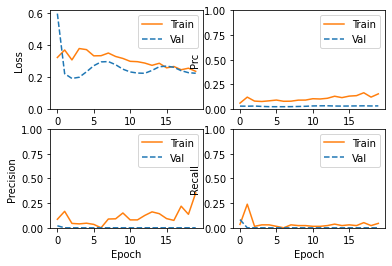

In [12]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color="C1", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="C0", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

In [13]:
val_loss = model.evaluate(x_test,y_test)
print(f"\nloss: {val_loss}")

predictions = model.predict(x_test)
print(predictions)

12/12 [==============================] - 0s 20ms/step - loss: 0.4796 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 314.0000 - fn: 42.0000 - accuracy: 0.8820 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6449 - prc: 0.1893

loss: [0.47955772280693054, 0.0, 0.0, 314.0, 42.0, 0.882022500038147, 0.0, 0.0, 0.6449044346809387, 0.18928049504756927]
[[1.02235235e-01]
 [5.70617653e-02]
 [7.05074053e-03]
 [5.59313012e-05]
 [4.47733477e-02]
 [1.22698480e-02]
 [2.93172169e-02]
 [1.11982450e-02]
 [4.66760527e-03]
 [3.97509895e-04]
 [2.43680109e-03]
 [2.11540377e-04]
 [1.60919712e-03]
 [7.89119825e-02]
 [1.01356149e-01]
 [2.06709146e-01]
 [1.03566691e-03]
 [1.46825789e-02]
 [3.28461044e-02]
 [7.53287924e-04]
 [3.17842253e-02]
 [1.08613528e-01]
 [4.43014838e-02]
 [4.08784859e-02]
 [8.29061493e-02]
 [1.46618010e-02]
 [6.04537576e-02]
 [7.35750096e-03]
 [2.56157247e-03]
 [1.99031070e-04]
 [9.74192396e-02]
 [1.32984605e-05]
 [3.88551354e-02]
 [2.86166724e-02]
 [1.40390126e-02]
 [1.50237209e-03]
 [2.30